In [13]:
from gensim.models import KeyedVectors
#EMBEDDING_FILE = '../word2vec/GoogleNews-vectors-negative300.bin.gz'
EMBEDDING_FILE = '../word2vec/glove.6B.100d.w2vformat.txt' 

In [73]:
import numpy as np 
import pandas as pd 

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
import keras.backend as K
from keras.optimizers import Adadelta, Adagrad, Adam

from nltk import word_tokenize

In [3]:
import itertools
import datetime
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv("../datasets/quora.csv")

In [5]:
train = data[:1000].copy(deep=True)
test = data[1000:2000].copy(deep=True)

In [6]:
def tokenize(s):
    s = s.lower()
    if s[-1] == '?':
        s = s[:-1]
        
    tokens = word_tokenize(s)
    return tokens

## Phrase to word indice vector
- Use only word found in pretrained word vector and ignore others

In [15]:
# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>'] 
if True:
    word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)

In [16]:
data.head()

,q1,q2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [17]:
# Iterate over the questions only of both training and test datasets
for dataset in [train, test]:
    for index, row in dataset.iterrows():
        #print(row)

        for question in ['q1', 'q2']:

            q2n = []
            for word in tokenize(row[question]):
                
                if word not in word2vec.vocab:
                    continue
            
                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)


## Embedding matrix

In [19]:
embedding_dim = 100
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)
        
print(embeddings.shape)

(6039, 100)


In [20]:
questions_cols = ['q1', 'q2']
max_length = 150

X_train = train[questions_cols]
Y_train = train['is_duplicate']
X_train = {'left': pad_sequences(X_train.q1, maxlen = max_length), 
           'right': pad_sequences(X_train.q2, maxlen = max_length)}
Y_train = Y_train.values

X_test = test[questions_cols]
Y_test = test['is_duplicate']
X_test = {'left': pad_sequences(X_test.q1, maxlen = max_length), 
           'right': pad_sequences(X_test.q2, maxlen = max_length)}
Y_test = Y_test.values


In [21]:
X_train

{'left': array([[   0,    0,    0, ...,   11,    9,   12],
        [   0,    0,    0, ...,   17,   18,   19],
        [   0,    0,    0, ...,   36,   37,   38],
        ..., 
        [   0,    0,    0, ...,  860,  345,  324],
        [   0,    0,    0, ..., 2732,  741, 3524],
        [   0,    0,    0, ...,  117, 2048, 2049]], dtype=int32),
 'right': array([[   0,    0,    0, ...,    9,   10,   11],
        [   0,    0,    0, ...,   18,   19,   26],
        [   0,    0,    0, ...,   41,   42,   43],
        ..., 
        [   0,    0,    0, ...,  407, 1664, 3811],
        [   0,    0,    0, ..., 2732,  741, 3524],
        [   0,    0,    0, ...,  964,    9, 3823]], dtype=int32)}

# Siamese + Manhattan error

In [24]:
# Model variables
n_hidden = 50
#gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 10

# exp ( - |a - b| (L1))
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_length,), dtype='int32')
right_input = Input(shape=(max_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), 
                            embedding_dim, 
                            weights=[embeddings], 
                            input_length=max_length, 
                            trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), 
                        output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta()

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_test['left'], X_test['right']], Y_test))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))
                                                       
print("Save model")                                                
malstm.save("../output/manhattan_siamese.h5")

/home/canh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/canh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:48: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3177 - acc: 0.6180 - val_loss: 0.2899 - val_acc: 0.6460

# Dense layer

In [50]:
from keras.layers import Concatenate, Dense, GRU

In [70]:
# Model variables
n_hidden = 50
n_dense_1 = 100
#gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 10


In [87]:
# The visible layer
left_input = Input(shape=(max_length,), dtype='int32')
right_input = Input(shape=(max_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), 
                            embedding_dim, 
                            weights=[embeddings], 
                            input_length=max_length, 
                            trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_gru = GRU(n_hidden)

left_output = shared_gru(encoded_left)
right_output = shared_gru(encoded_right)

# concatenate outputs
merge_output = Concatenate(axis=-1)([left_output, right_output])
merge_output.shape

#Dense layer
dense_layer = Dense(units=n_dense_1, activation="relu")(merge_output)
output = Dense(units=2, activation="softmax")(dense_layer)

# Pack it all up into a model
model = Model([left_input, right_input], output)


# Adadelta optimizer, with gradient clipping by norm
optimizer = Adam(lr = 0.0001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

model_trained = model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_test['left'], X_test['right']], Y_test))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))
                                                       
print("Save model")                                                
model.save("../output/dense_layer_siamese.h5")

/home/canh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6779 - acc: 0.5770 - val_loss: 0.6700 - val_acc: 0.6220

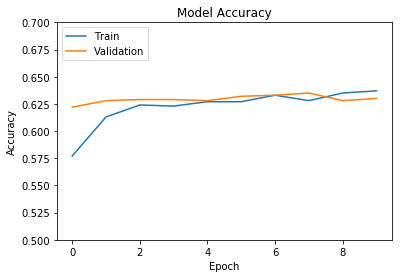

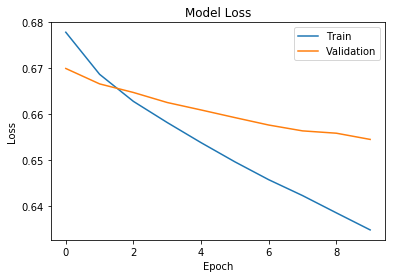

In [95]:
# Plot accuracy
plt.plot(model_trained.history['acc'])
plt.plot(model_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0.5,0.7])
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(model_trained.history['loss'])
plt.plot(model_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()